In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.regularizers import l2

2024-11-30 15:03:45.098039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 15:03:45.480366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 15:03:45.529959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 15:03:46.640465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Food-101 dataset
dataset_name = 'food101'
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name,
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Print dataset information
print("Dataset info:")
print(ds_info)


I0000 00:00:1732953843.890507    4171 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732953846.406869    4171 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732953846.407234    4171 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732953846.429140    4171 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset info:
tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/home/prjnaa/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

d negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732953846.429512    4171 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732953846.693115    4171 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732953846.693296    4171 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See mo

In [3]:
# Get the number of classes
num_classes = ds_info.features['label'].num_classes
print("Number of classes:", num_classes)

# Get class names
class_names = ds_info.features['label'].names
print("Class names:", class_names[40:50])


Number of classes: 101
Class names: ['french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich']


2024-11-30 15:04:18.388699: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


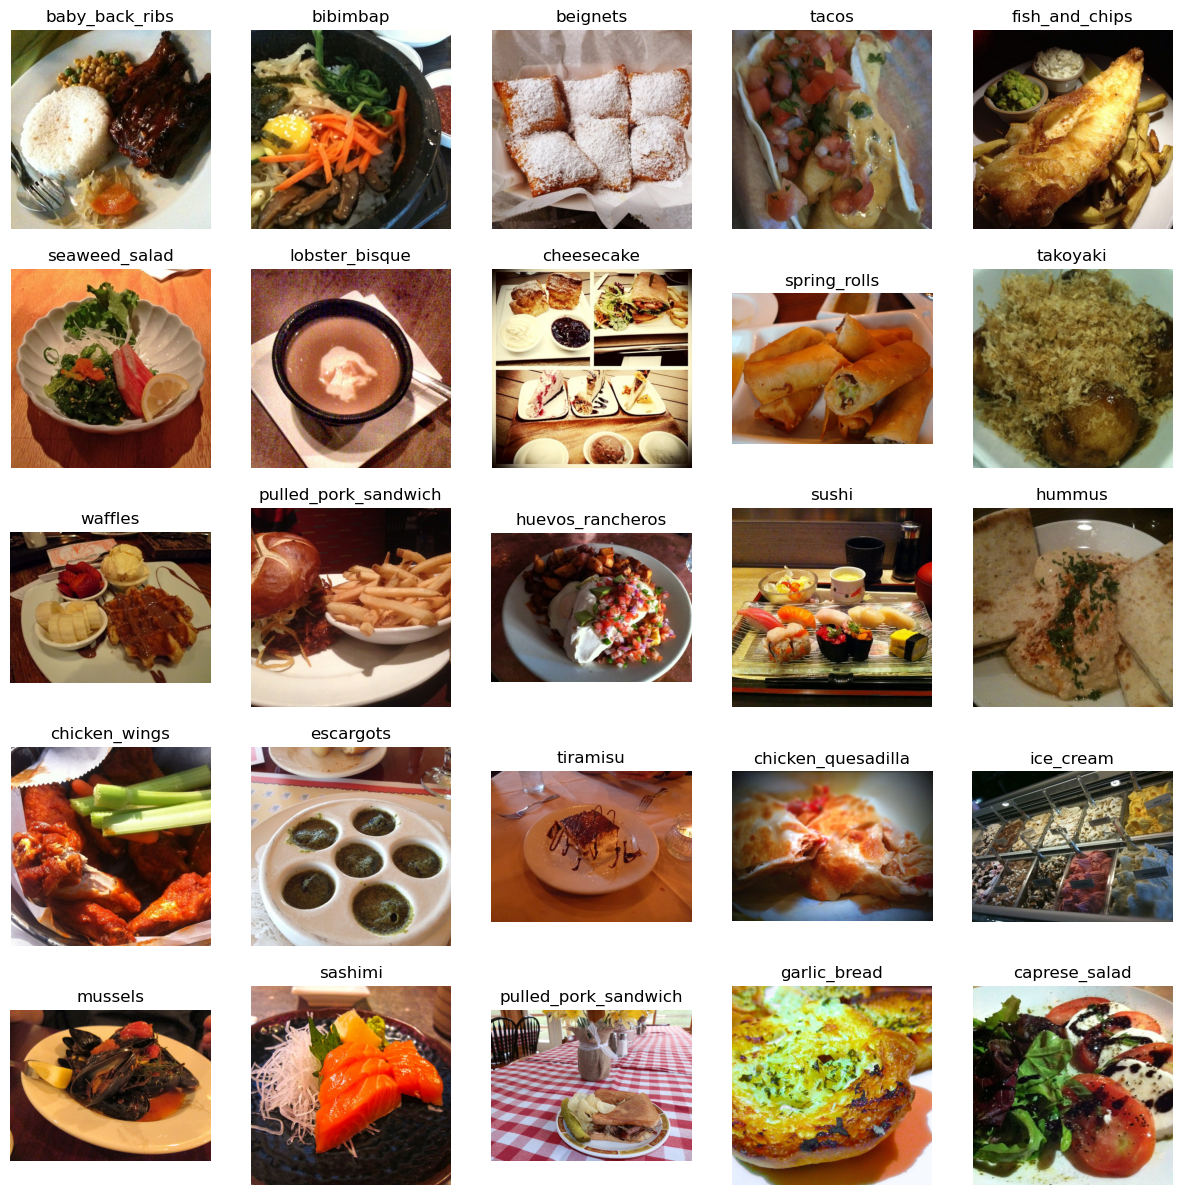

In [4]:
# Function to show images
def show_images(dataset, num_images):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title(class_names[label.numpy()])
        plt.axis("off")

# Show 25 images from the training set
show_images(ds_train, 25)

In [5]:
# Define image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
])

# Function to preprocess images (resize and normalize)
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize the image
    image = image / 255.0  # Normalize the image to [0,1] range
    return image, label

# Data augmentation
ds_train = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# Data preprocess
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Preprocess test dataset (no augmentation)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [7]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                        include_top=False,
                        weights='imagenet')

# Freeze base model
base_model.trainable = False

# Add custom layers on top of the base model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Define the model
model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,387,365 (9.11 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
total_epochs = 30
checkpoint_path = "training_checkpoints/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True, verbose=1)

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

latest = tf.train.latest_checkpoint(checkpoint_dir)

if latest:
    print(f"Memuat bobot model dari {latest}")
    model.load_weights(latest)
    # Ekstrak nomor epoch terakhir
    initial_epoch = int(latest.split('-')[1].split('.')[0])
else:
    initial_epoch = 0


In [9]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    callbacks=[cp_callback, lr_scheduler, early_stop]
)

Epoch 1/30


I0000 00:00:1732953947.642233    4700 service.cc:146] XLA service 0x7e1228111080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732953947.642255    4700 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-11-30 15:05:48.466683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 15:05:49.672678: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2024-11-30 15:05:52.374192: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1829', 268 bytes spill stores, 268 bytes spill loads

2024-11-30 15:05:52.375752: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in 

   3/2368 ━━━━━━━━━━━━━━━━━━━━ 2:12 56ms/step - accuracy: 0.0278 - loss: 7.6640   

I0000 00:00:1732953959.670413    4700 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2454 - loss: 4.3748

2024-11-30 15:10:51.751886: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1829', 144 bytes spill stores, 144 bytes spill loads

2024-11-30 15:10:51.767642: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1829', 116 bytes spill stores, 116 bytes spill loads



2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2454 - loss: 4.3742

2024-11-30 15:10:57.195677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1175', 16 bytes spill stores, 16 bytes spill loads

2024-11-30 15:10:57.367309: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1175', 340 bytes spill stores, 340 bytes spill loads

2024-11-30 15:10:57.543430: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1175', 100 bytes spill stores, 100 bytes spill loads

2024-11-30 15:11:12.260432: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1175', 4 bytes spill stores, 4 bytes spill loads

2024-11-30 15:11:12.618535: I external/local_xla/xla/strea


Epoch 1: saving model to training_checkpoints/cp-0001.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 335s 133ms/step - accuracy: 0.2454 - loss: 4.3739 - val_accuracy: 0.4738 - val_loss: 2.8699 - learning_rate: 0.0010
Epoch 2/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3604 - loss: 3.3232
Epoch 2: saving model to training_checkpoints/cp-0002.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 313s 130ms/step - accuracy: 0.3604 - loss: 3.3232 - val_accuracy: 0.4730 - val_loss: 2.8719 - learning_rate: 0.0010
Epoch 3/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3597 - loss: 3.3238
Epoch 3: saving model to training_checkpoints/cp-0003.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 315s 131ms/step - accuracy: 0.3597 - loss: 3.3238 - val_accuracy: 0.4830 - val_loss: 2.8459 - learning_rate: 0.0010
Epoch 4/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3600 - loss: 3.3231
Epoch 4: saving model to training_checkpoints/cp-0004.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━

2024-11-30 17:17:58.320122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:117: Filling up shuffle buffer (this may take a while): 430 of 1000


   1/2368 ━━━━━━━━━━━━━━━━━━━━ 9:33:43 15s/step - accuracy: 0.5000 - loss: 2.5356

2024-11-30 17:18:02.657341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4258 - loss: 2.8989
Epoch 26: saving model to training_checkpoints/cp-0026.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 330s 133ms/step - accuracy: 0.4257 - loss: 2.8989 - val_accuracy: 0.5398 - val_loss: 2.5372 - learning_rate: 1.2500e-04
Epoch 27/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4238 - loss: 2.8992
Epoch 27: saving model to training_checkpoints/cp-0027.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 317s 132ms/step - accuracy: 0.4238 - loss: 2.8992 - val_accuracy: 0.5402 - val_loss: 2.5376 - learning_rate: 1.2500e-04
Epoch 28/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4251 - loss: 2.8977
Epoch 28: saving model to training_checkpoints/cp-0028.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 316s 131ms/step - accuracy: 0.4251 - loss: 2.8977 - val_accuracy: 0.5378 - val_loss: 2.5425 - learning_rate: 1.2500e-04
Epoch 29/30
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4284 - loss: 2.89

In [17]:
# Unfreeze the base model
base_model.trainable = True

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 5
total_epoch = initial_epoch + fine_tune_epochs


In [18]:
history_fine = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

Epoch 20/20


2024-11-30 02:10:18.377908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:242: Filling up shuffle buffer (this may take a while): 262 of 1000
2024-11-30 02:10:23.152511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-11-30 02:10:45.578065: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[32,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[32,32,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-11-30 02:10:46.445138: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1

2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3716 - loss: 3.1586

2024-11-30 02:17:17.990822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 188 bytes spill stores, 188 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion', 236 bytes spill stores, 244 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 44 bytes spill stores, 44 bytes spill loads



2368/2368 ━━━━━━━━━━━━━━━━━━━━ 559s 172ms/step - accuracy: 0.3717 - loss: 3.1584 - val_accuracy: 0.5874 - val_loss: 2.1138


In [19]:
# Evaluate on the test set
loss, accuracy = model.evaluate(ds_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")


790/790 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5871 - loss: 2.1096
Test accuracy: 58.74%


In [ ]:
model.save("Food101_MobileNetV2_v1.0.h5")

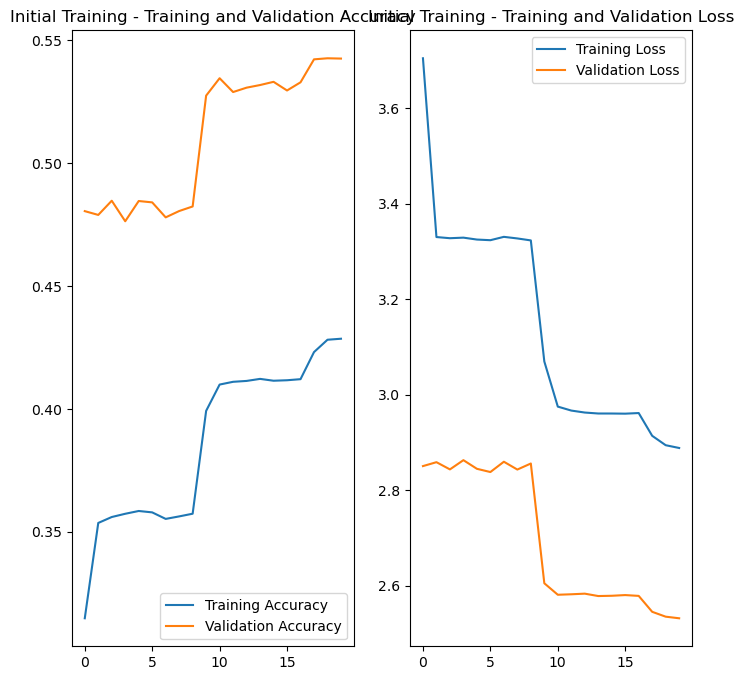

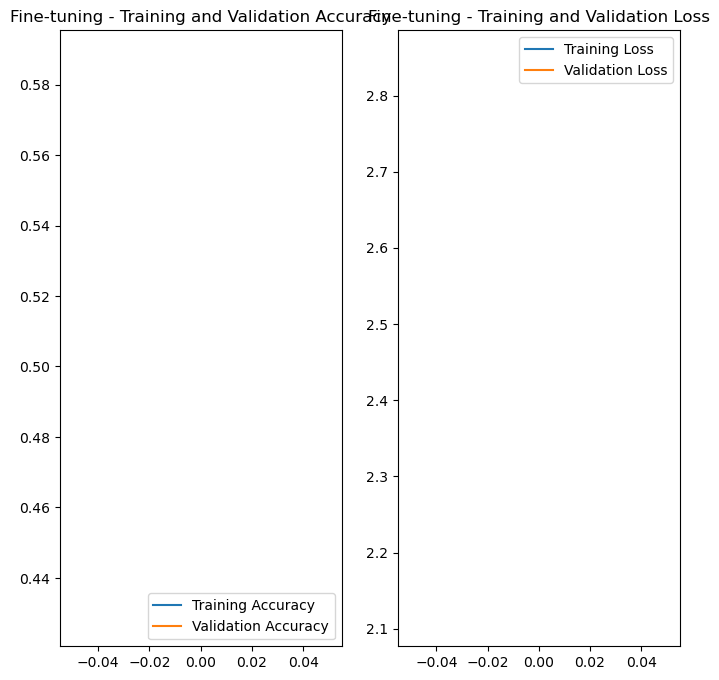

In [20]:
# Function to plot training history
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(len(acc))

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title(f'{title} - Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title(f'{title} - Training and Validation Loss')
        plt.show()

# Plot the training history
plot_history([history, history_fine], ["Initial Training", "Fine-tuning"])


In [21]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set optimization flag (optional for quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the model to a .tflite file
tflite_model_file = 'food_detection_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite and saved as", tflite_model_file)


INFO:tensorflow:Assets written to: /tmp/tmp8alinlw2/assets


INFO:tensorflow:Assets written to: /tmp/tmp8alinlw2/assets


Saved artifact at '/tmp/tmp8alinlw2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_321')
Output Type:
  TensorSpec(shape=(None, 101), dtype=tf.float32, name=None)
Captures:
  132612189328912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132612189331216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132612189329680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132612189331408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132612189329104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132612189330256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610206009488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610206009680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132612189328528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132612189326992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13261020

W0000 00:00:1732907977.076993   97434 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1732907977.147556   97434 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-30 02:19:37.225644: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8alinlw2
2024-11-30 02:19:37.231488: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-30 02:19:37.231504: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8alinlw2
2024-11-30 02:19:37.417799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-11-30 02:19:37.438130: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-30 02:19:37.873614: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp8alinlw2
2024-11-30 02:19:37.964417: I tensorflow/cc/saved_model/loader.cc

In [18]:
# Create labels.txt file
labels = '\n'.join(class_names)
with open('labels.txt', 'w') as f:
    f.write(labels)


NameError: name 'files' is not defined

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for image, label in ds_test.take(1):
    input_image = np.expand_dims(image[0].numpy(), axis=0).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], input_image)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_label = np.argmax(output_data[0])

# Print the predicted label and true label
print("Predicted label:", class_names[predicted_label])
print("True label:", class_names[label[0].numpy()])


In [ ]:
print(os.listdir(checkpoint_dir))